In [202]:
#https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/

import pandas as pd 
import numpy as np 
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from numpy import array

C:\Users\Techatach\AppData\Local\Temp\ipykernel_24524\3033094570.py:9: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [203]:
#df.to_csv('WorldCovid.csv')

df = pd.read_csv('owid-covid-data.csv', usecols=[2,3,4,5,7,8], engine='python')
df.dropna()

,location,date,total_cases,new_cases,total_deaths,new_deaths
28,Afghanistan,2020-03-23,40.0,6.0,1.0,1.0
29,Afghanistan,2020-03-24,42.0,2.0,1.0,0.0
30,Afghanistan,2020-03-25,74.0,32.0,1.0,0.0
31,Afghanistan,2020-03-26,80.0,6.0,2.0,1.0
32,Afghanistan,2020-03-27,91.0,11.0,2.0,0.0
...,...,...,...,...,...,...
167702,Zimbabwe,2022-03-06,239209.0,190.0,5399.0,2.0
167703,Zimbabwe,2022-03-07,239710.0,501.0,5399.0,0.0
167704,Zimbabwe,2022-03-08,240343.0,633.0,5400.0,1.0
167705,Zimbabwe,2022-03-09,240343.0,0.0,5400.0,0.0


In [204]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167708 entries, 0 to 167707
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   location      167708 non-null  object 
 1   date          167708 non-null  object 
 2   total_cases   164661 non-null  float64
 3   new_cases     164506 non-null  float64
 4   total_deaths  146765 non-null  float64
 5   new_deaths    146798 non-null  float64
dtypes: float64(4), object(2)
memory usage: 7.7+ MB


In [205]:
#th = df.loc[df['location'].isin(['Thailand'])].dropna() #.set_index('date')
import matplotlib.pyplot as plt 

data = pd.read_csv('WorldCovid.csv', usecols=[1,2,3], engine='python') 
data 

# # line plot
# data.plot()
# plt.show()

,location,date,total_cases
0,Afghanistan,2020-02-24,5.0
1,Afghanistan,2020-02-25,5.0
2,Afghanistan,2020-02-26,5.0
3,Afghanistan,2020-02-27,5.0
4,Afghanistan,2020-02-28,5.0
...,...,...,...
167703,Zimbabwe,2022-03-07,239710.0
167704,Zimbabwe,2022-03-08,240343.0
167705,Zimbabwe,2022-03-09,240343.0
167706,Zimbabwe,2022-03-10,241548.0


In [206]:
s = data.loc[data['location'].isin(['Thailand'])].dropna() #.set_index('date')
s

,location,date,total_cases
149571,Thailand,2020-01-22,4.0
149572,Thailand,2020-01-23,4.0
149573,Thailand,2020-01-24,5.0
149574,Thailand,2020-01-25,6.0
149575,Thailand,2020-01-26,8.0
...,...,...,...
150346,Thailand,2022-03-07,3066800.0
150347,Thailand,2022-03-08,3088873.0
150348,Thailand,2022-03-09,3111857.0
150349,Thailand,2022-03-10,3136649.0


In [207]:
series = s.loc[:,['total_cases']].reset_index()
series = series.drop(['index'], axis=1)
series 

,total_cases
0,4.0
1,4.0
2,5.0
3,6.0
4,8.0
...,...
775,3066800.0
776,3088873.0
777,3111857.0
778,3136649.0


In [208]:
# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [209]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

In [210]:
# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
	# extract raw values
	raw_values = series.values
	# transform data to be stationary
	diff_series = difference(raw_values, 1)
	diff_values = diff_series.values
	diff_values = diff_values.reshape(len(diff_values), 1)
	# rescale values to -1, 1
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaled_values = scaler.fit_transform(diff_values)
	scaled_values = scaled_values.reshape(len(scaled_values), 1)
	# transform into supervised learning problem X, y
	supervised = series_to_supervised(scaled_values, n_lag, n_seq)
	supervised_values = supervised.values
	# split into train and test sets
	train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
	return scaler, train, test

In [211]:
# fit an LSTM network to training data
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
	# reshape training into [samples, timesteps, features]
	X, y = train[:, 0:n_lag], train[:, n_lag:]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	# design network
	model = Sequential()
	model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(y.shape[1]))
	model.compile(loss='mean_squared_error', optimizer='adam')
	# fit network
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
		model.reset_states()
	return model

In [212]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (1, 1)                    12        
                                                                 
 dense_2 (Dense)             (1, 3)                    6         
                                                                 
Total params: 18
Trainable params: 18
Non-trainable params: 0
_________________________________________________________________


In [213]:
# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
	# reshape input pattern to [samples, timesteps, features]
	X = X.reshape(1, 1, len(X))
	# make forecast
	forecast = model.predict(X, batch_size=n_batch)
	# convert to array
	return [x for x in forecast[0, :]]

In [214]:
# evaluate the persistence model
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
	forecasts = list()
	for i in range(len(test)):
		X, y = test[i, 0:n_lag], test[i, n_lag:]
		# make forecast
		forecast = forecast_lstm(model, X, n_batch)
		# store the forecast
		forecasts.append(forecast)
	return forecasts

In [215]:
# invert differenced forecast
def inverse_difference(last_ob, forecast):
	# invert first forecast
	inverted = list()
	inverted.append(forecast[0] + last_ob)
	# propagate difference forecast using inverted first value
	for i in range(1, len(forecast)):
		inverted.append(forecast[i] + inverted[i-1])
	return inverted

In [216]:
# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
	inverted = list()
	for i in range(len(forecasts)):
		# create array from forecast
		forecast = array(forecasts[i])
		forecast = forecast.reshape(1, len(forecast))
		# invert scaling
		inv_scale = scaler.inverse_transform(forecast)
		inv_scale = inv_scale[0, :]
		# invert differencing
		index = len(series) - n_test + i - 1
		last_ob = series.values[index]
		inv_diff = inverse_difference(last_ob, inv_scale)
		# store
		inverted.append(inv_diff)
	return inverted

In [217]:
# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
	for i in range(n_seq):
		actual = [row[i] for row in test]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = sqrt(mean_squared_error(actual, predicted))
		print('t+%d RMSE: %f' % ((i+1), rmse))

In [218]:
# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
	# plot the entire dataset in blue
	pyplot.plot(series.values)
	# plot the forecasts in red
	for i in range(len(forecasts)):
		off_s = len(series) - n_test + i - 1
		off_e = off_s + len(forecasts[i]) + 1
		xaxis = [x for x in range(off_s, off_e)]
		yaxis = [series.values[off_s]] + forecasts[i]
		pyplot.plot(xaxis, yaxis, color='red')
	# show the plot
	pyplot.show()

t+1 RMSE: 8974.053884
t+2 RMSE: 12691.988050
t+3 RMSE: 16779.607073


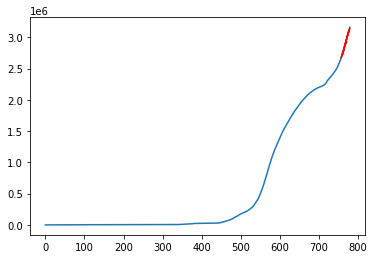

In [255]:
# load dataset
#series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# configure
n_lag = 1
n_seq = 3
n_test = 20
# n_epochs=1500
n_epochs = 20
n_batch = 1
n_neurons = 1
# prepare data
scaler, train, test = prepare_data(series, n_test, n_lag, n_seq)
# fit model
model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)
# make forecasts
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
# inverse transform forecasts and test
forecasts = inverse_transform(series, forecasts, scaler, n_test+2)
actual = [row[n_lag:] for row in test]
actual = inverse_transform(series, actual, scaler, n_test+2)
# evaluate forecasts
evaluate_forecasts(actual, forecasts, n_lag, n_seq)
# plot forecasts
plot_forecasts(series, forecasts, n_test+2)

In [256]:
predict = pd.DataFrame(forecasts)
predict 

,0,1,2
0,[2691173.318359375],[2707823.318359375],[2724467.61328125]
1,[2710571.693359375],[2727725.486328125],[2744867.16796875]
2,[2729784.16015625],[2747192.576171875],[2764585.646484375]
3,[2748760.955078125],[2766261.416015625],[2783745.359375]
4,[2766984.51953125],[2784348.14453125],[2801696.994140625]
5,[2789071.7421875],[2807274.626953125],[2825452.06640625]
6,[2813633.822265625],[2832823.02734375],[2851974.24609375]
7,[2839332.74609375],[2859274.560546875],[2879168.822265625]
8,[2865443.8203125],[2885872.451171875],[2906247.337890625]
9,[2890271.03125],[2910805.8515625],[2931285.578125]


In [257]:
actual = pd.DataFrame(actual)
actual

,0,1,2
0,[2693362.0],[2712315.0],[2731198.0]
1,[2712315.0],[2731198.0],[2749561.0]
2,[2731198.0],[2749561.0],[2770793.0]
3,[2749561.0],[2770793.0],[2794350.0]
4,[2770793.0],[2794350.0],[2819282.0]
5,[2794350.0],[2819282.0],[2844897.0]
6,[2819282.0],[2844897.0],[2869616.0]
7,[2844897.0],[2869616.0],[2891927.0]
8,[2869616.0],[2891927.0],[2891927.0]
9,[2891927.0],[2891927.0],[2934544.0]
